In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

### Read Data

In [2]:
# Read in the data
dataset = "ds1"

### Barcode mapping
subject2barcode = {}
barcode2subject = {}
with open(f"{dataset}/{dataset}_Barcodes.dat") as f:
    for _ in range(4):
        next(f)
    
    for line in f:
        subject, barcode = map(int, line.strip().split())
        subject2barcode[subject] = barcode
        barcode2subject[barcode] = subject

### Landmark GT
landmark_gt = pd.read_csv(f"{dataset}/{dataset}_Landmark_Groundtruth.dat", sep="\s+", skiprows=4, 
                          names=["Subject #", "x [m]", "y [m]", "x std-dev [m]", "y std-dev [m]"])

### Robot GT
gt = pd.read_csv(f"{dataset}/{dataset}_Groundtruth.dat", sep="\s+", skiprows=4,
                 names=["Time [s]", "x [m]", "y [m]", "Orientation [rad]"])

### Robot Measurements
msmt = pd.read_csv(f"{dataset}/{dataset}_Measurement.dat", sep="\s+", skiprows=4,
                   names=["Time [s]", "Subject #", "Range [m]", "Bearing [rad]"])

### Robot Odometry
odo = pd.read_csv(f"{dataset}/{dataset}_Odometry.dat", sep="\s+", skiprows=4,
                  names=["Time [s]", "Forward Velocity [m/s]", "Angular Velocity [rad/s]"])

In [22]:
odo['Angular Velocity [rad/s]'].min()

-1.003

In [3]:
# Get landmark gts and stuff

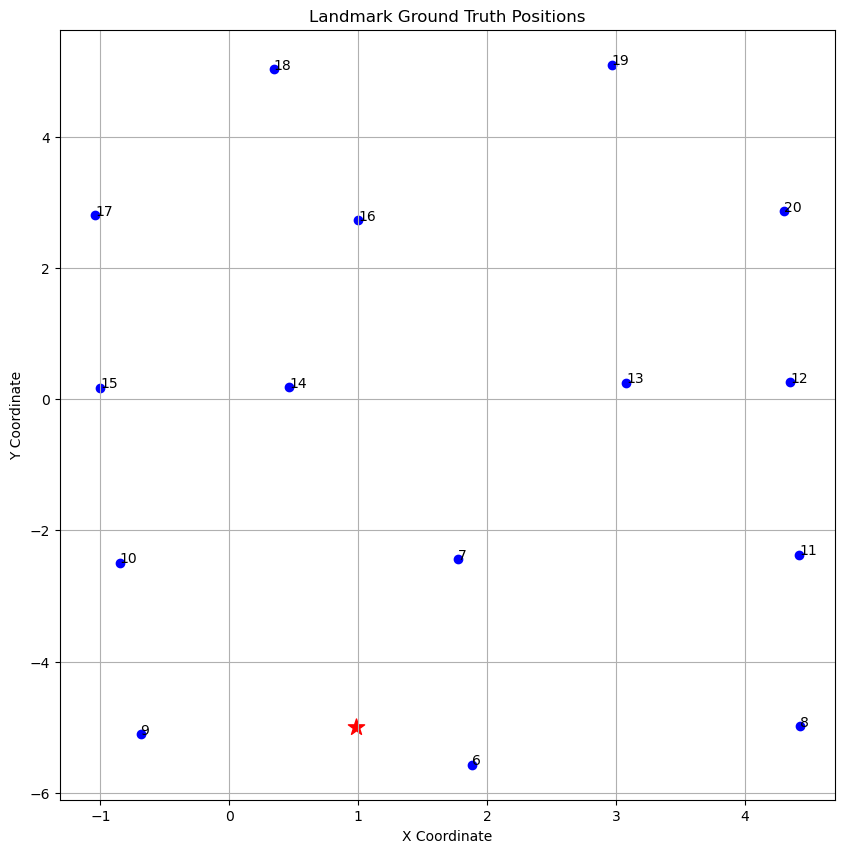

In [4]:
# Plot out the landmarks

xcoords = landmark_gt['x [m]']
ycoords = landmark_gt['y [m]']
plt.figure(figsize=(10, 10))
plt.scatter(xcoords, ycoords, marker='o', c='b')

# Annotate each point with its subject number
for i, txt in enumerate(landmark_gt['Subject #']):
    plt.annotate(txt, (xcoords[i], ycoords[i]))

# plot robot start posn
robot_start_x = 0.98
robot_start_y = -4.99
plt.scatter(robot_start_x, robot_start_y, marker='*', c='r', s=150, label='Robot Start Position')  # s sets the marker size

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Landmark Ground Truth Positions')
plt.grid(True)
plt.show()

### Converting the dataframe

In [36]:
# Define a small time unit
EPSILON = 1e-9

# Combining all data and sorting
all_data = pd.concat([odo, msmt])
all_data = all_data.sort_values(by='Time [s]')

# New dataframe to hold the reordered data
restructured_data = []

# Use a list to keep track of the set of measurements after an action step
last_measurements = []

In [37]:
all_data

,Time [s],Forward Velocity [m/s],Angular Velocity [rad/s],Subject #,Range [m],Bearing [rad]
0,1.288972e+09,0.000,0.000,NaN,NaN,NaN
1,1.288972e+09,NaN,NaN,14.0,2.137,-0.077
0,1.288972e+09,NaN,NaN,9.0,5.521,-0.274
1,1.288972e+09,0.000,0.000,NaN,NaN,NaN
2,1.288972e+09,0.000,0.000,NaN,NaN,NaN
...,...,...,...,...,...,...
6165,1.288973e+09,NaN,NaN,16.0,3.380,0.075
11521,1.288973e+09,0.165,-1.003,NaN,NaN,NaN
6166,1.288973e+09,NaN,NaN,16.0,3.310,0.194
11522,1.288973e+09,0.165,-1.003,NaN,NaN,NaN


In [24]:
# Iterate through the combined data
for i, (idx, row) in enumerate(all_data.iterrows()):
    # Identify the type of data based on columns
    if "v" in row and "omega" in row:  # This is odometry data
        # Get the closest groundtruth
        closest_gt_idx = (gt['Time [s]'] - row['Time [s]']).abs().idxmin()
        closest_gt = gt.loc[closest_gt_idx].copy()
        
        # Adjust the timestamp to ensure order
        closest_gt['time'] = row['time'] + EPSILON

        restructured_data.append(row)
        restructured_data.append(closest_gt)

        # If this isn't the last row and the next row is also an odometry row
        if i < len(all_data) - 1 and "v" in all_data.iloc[i+1] and "omega" in all_data.iloc[i+1]:
            next_action_time = all_data.iloc[i+1]['time']
            # Check if there are any measurements between current action and next action
            measurements_in_between = msmt[(msmt['time'] > row['time']) & (msmt['time'] < next_action_time)]
            if measurements_in_between.empty:
                for measure in last_measurements:
                    updated_measure = measure.copy()
                    updated_measure['time'] = row['time'] + 2*EPSILON
                    restructured_data.append(updated_measure)

    elif "subject" in row and "range" in row and "bearing" in row:  # This is measurement data
        last_measurements.append(row)
        restructured_data.append(row)

In [ ]:
# Convert back to a DataFrame
restructured_df = pd.DataFrame(restructured_data).sort_values(by='time')

In [38]:
len(odo)

11524

In [39]:
len(msmt)

6167

In [10]:
gt["Time [s]"]

0         1.288972e+09
1         1.288972e+09
2         1.288972e+09
3         1.288972e+09
4         1.288972e+09
              ...     
125920    1.288973e+09
125921    1.288973e+09
125922    1.288973e+09
125923    1.288973e+09
125924    1.288973e+09
Name: Time [s], Length: 125925, dtype: float64

In [11]:
# find closest gt for row in odometry
def find_closest_groundtruth_row(odometry_time):
    # Calculate the absolute difference between the odometry timestamp and all groundtruth timestamps
    time_diffs = abs(gt["Time [s]"] - odometry_time)
    
    # Find the index of the smallest difference
    closest_idx = time_diffs.idxmin()
    
    # Return the closest groundtruth row
    return gt.iloc[closest_idx]

In [19]:
find_closest_groundtruth_row(odo["Time [s]"][0])[-["Time [s]"]]

TypeError: bad operand type for unary -: 'list'

### 2. Motion model
![motion_model](motion_model.jpg)

### Robot with motion and measurement model

In [11]:
class Robot:
    def __init__(self, x=0.0, y=0.0, theta=0.0):
        # initial pose
        self.x = x
        self.y = y
        self.theta = theta

    def move(self, v, omega, dt):
        """
        Update the robot's position using the velocity motion model.
        
        v: Forward velocity.
        omega: Angular velocity.
        dt: Time duration.
        """
        
        # If the robot is moving approximately straight
        if abs(omega) < 1e-10:
            self.x += v * dt * math.cos(self.theta)
            self.y += v * dt * math.sin(self.theta)
            # Orientation remains the same when omega is zero
        else:
            self.x += (v/omega) * (math.sin(self.theta + omega*dt) - math.sin(self.theta))
            self.y += (v/omega) * (math.cos(self.theta) - math.cos(self.theta + omega*dt))
            self.theta += omega * dt
            self.theta = self._normalize_angle(self.theta)


    def predict_measurement(self, landmark):
        # Compute expected range and bearing
        delta_x = landmark[0] - self.x
        delta_y = landmark[1] - self.y
        
        r_expected = math.sqrt(delta_x**2 + delta_y**2)
        phi_expected = self._normalize_angle(math.atan2(delta_y, delta_x) - self.theta)
        
        return r_expected, phi_expected

    def _normalize_angle(self, angle):
        """
        Normalize an angle to be between -pi and pi.
        """
        while angle > math.pi:
            angle -= 2.0 * math.pi
        while angle < -math.pi:
            angle += 2.0 * math.pi
        return angle

# robot = Robot()
# robot.move(v=1.0, omega=0.5, dt=1.0)
# print(f"New position: x={robot.x}, y={robot.y}, theta={robot.theta}")


### 2. Motion model with following sequence of commands

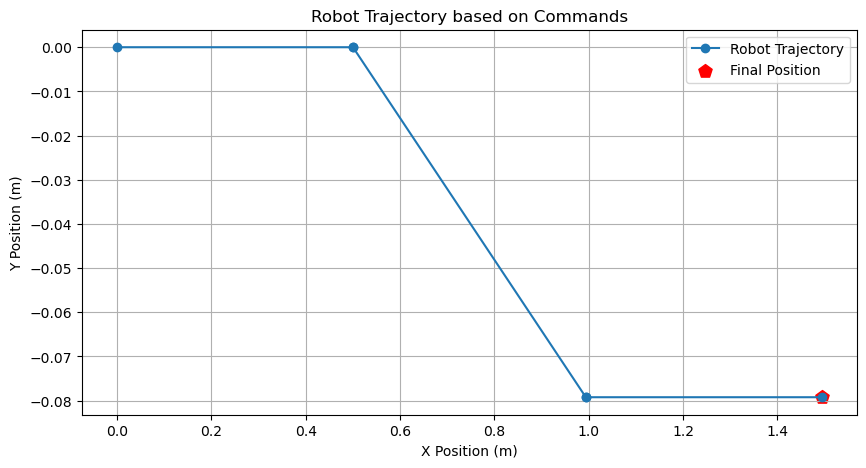

In [12]:
# Initialize the robot's position
robot = Robot(x=0, y=0, theta=0)

# Store the initial position for plotting
x_trajectory = [robot.x]
y_trajectory = [robot.y]

# Sequence of commands
# [v, w, t]
commands = [
    (0.5, 0, 1),          
    (0, -1/(2*math.pi), 1),
    (0.5, 0, 1),
    (0, 1/(2*math.pi), 1),
    (0.5, 0, 1)
]

# Execute each command
for v, omega, dt in commands:
    robot.move(v, omega, dt)
    x_trajectory.append(robot.x)
    y_trajectory.append(robot.y)

# Plot the trajectory
plt.figure(figsize=(10, 5))
plt.plot(x_trajectory, y_trajectory, '-o', label='Robot Trajectory')
plt.scatter(robot.x, robot.y, c='red', marker='p', s=100, label='Final Position')  # mark final position with a star
plt.title('Robot Trajectory based on Commands')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.grid(True)
plt.show()


The expected behavior for applying the given controls should be the following:
Init: robot at 0,0 facing x-axis
1. robot moves 0.5 meters due east
2. robot turns south (negative) by approx 9.12 degrees)
3. robot travels for 0.5 meters
4. robot turns back to due east
5. robot travels for 0.5 meters

By quick trig, we expect to be south of y=0 due to the turn by sin(9.12deg)*0.5 ≈ 0.08 meters which is in line with the plot

### 3. Compare dead-reckoned path (controls propagation only) to ground truth path

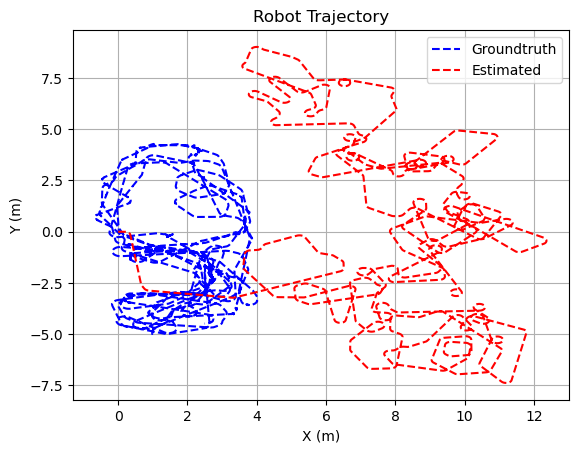

In [13]:
# GT Path
plt.plot(gt["x [m]"], gt["y [m]"], label="Groundtruth", linestyle='--', color='blue')


# Calculated dead-reckoned path
# apply controls from odometry.dat to robot and record and plot estimated trajectory

# assuming starting at 0,0 facing east
robot = Robot(x=0, y=0, theta=0)

# assuming starting at the 1st pose in the groundtruth
# robot = Robot(x=gt.iloc[0][1], y=gt.iloc[0][2], theta=gt.iloc[0][3])
estimated_x = [robot.x]
estimated_y = [robot.y]

for i in range(1, len(odo)):
    dt = odo.iloc[i][0] - odo.iloc[i-1][0]
    robot.move(odo.iloc[i][1], odo.iloc[i][2], dt)
    estimated_x.append(robot.x)
    estimated_y.append(robot.y)

# Plot estimated trajectory
plt.plot(estimated_x, estimated_y, label='Estimated', linestyle='--', color='red')

plt.legend()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Robot Trajectory')
plt.grid(True)
plt.show()

The difference in ground truth and the robot's model of the world based on odometry controls is quite large. We see that from the get go the robot's model ventures far from the origin and then all movements are "larger/emphasized" than what they actually are. This I think is to be expected since it does not account for slippage or other forces that the robot in the physical world will need to encounter in order to move. Hence, I think the enlargement of the robot's model is justifiable. However, one aspect I can't quite explain is the difference in loops. I'd expect even if the robot's model to be emphasized the overall shape should be similar and currently I'm on the fence to saying whether or not the two motions have similar shape.

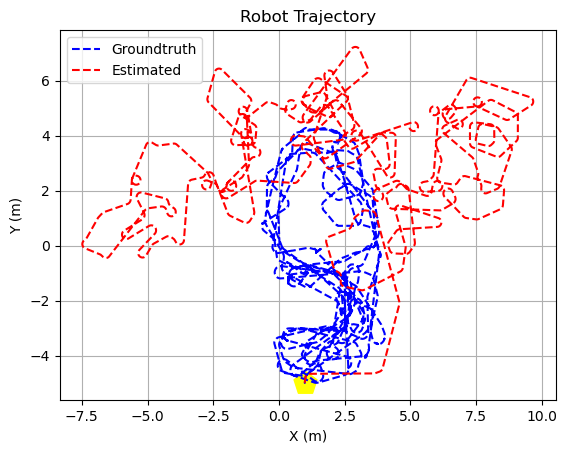

In [14]:
# GT Path
plt.plot(gt["x [m]"], gt["y [m]"], label="Groundtruth", linestyle='--', color='blue')


# Calculated dead-reckoned path
# apply controls from odometry.dat to robot and record and plot estimated trajectory

# Starting position:


start_pose = (gt.iloc[0][1], gt.iloc[0][2], gt.iloc[0][3])
plt.scatter(start_pose[0], start_pose[1], marker='p', s=300, color='yellow')

# assuming starting at the 1st pose in the groundtruth
robot = Robot(*start_pose)
estimated_x = [robot.x]
estimated_y = [robot.y]

for i in range(1, len(odo)):
    dt = odo.iloc[i][0] - odo.iloc[i-1][0]
    robot.move(odo.iloc[i][1], odo.iloc[i][2], dt)
    estimated_x.append(robot.x)
    estimated_y.append(robot.y)

# Plot estimated trajectory
plt.plot(estimated_x, estimated_y, label='Estimated', linestyle='--', color='red')

plt.legend()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Robot Trajectory')
plt.grid(True)
plt.show()

One big assumption made when plotting is that the robot starts at 0,0 with theta=0 (facing in the positive x-axis). When trying to account for this by starting the robot in the last known (ground truth) pose, the plotted figure looks even more different. I think the explanation for this is the orientation drift of the model is quite large, such that after a few turns the mental model of the robot will be very off the reality. Hence making the plot very different.

Another aspect is the choice of dt. With a fine granularity of dt the robot makes many frequent adjustments to its mental model but I think the errors accumulate and there is a lot of uncertainty as to where the robot is. If the data had lower fidelity then perhaps after applying the movements of the odometry file as long as the essential changes in movement are captured in that fidelity then the plotted path could be closer to the ground truth.

### 4. Filtering algorithm: Unscented Kalman Filter

The filtering algorithm I will use is the Unscented Kalman Filter (UKF). The is a generalization of the Kalman Filter that allows for non-linear motion and measurement models such as the ones described above and below. The UKF works by approximating the probability distribution of the system's state by transforming a set of points called sigma points (SP) through the non-linear functions g and h (motion and measurement). The UKF allows for non-linear transformations, is more performant than EKF at non-linear movements and is the same as KF in linear cases, and does not need to compute the Jacobian.

1. Alg_UKF($\mu_{t-1}, \Sigma_{t-1}, u_{t}, z_{t}$)
    - (Given mean and variance of gaussian at previous time step, action taken at current step and the measurement of the current step)

2. $\Chi_{t-1} = \{\mu_{t-1} , \mu_{t-1} + \gamma\sqrt{\Sigma_{t-1}}, \mu_{t-1} - \gamma\sqrt{\Sigma_{t-1}} \}$
    - Let $\Chi_{t-1}$ be the set of SP from the previous time step. Consists of the previous mean and 2 points for each step in either direction of the mean for n dimensions of the Gaussian.
    - $\lambda = \alpha^2(n + \kappa) - n$ where $\alpha$ and $\kappa$ being parameters that determine how far the sigma points are spread from the mean
    - note, each SP has 2 weights $w_m, w_c$ associated with it used for computing the next mean and covariance
        - $w_m^{[0]} = \frac{\lambda}{n+\lambda}$
        - $w_c^{[0]} = \frac{\lambda}{n+\lambda} + (1 - \alpha^2 + \beta)$
        - $w_m^{[i]} = w_c^{[i]} = \frac{\lambda}{2(n+\lambda)}$ for $i \in [1,2n]$

3. $\bar{\Chi_t} = g(u_t, \Chi_{t-1})$
    - Pass the previous set of SP and the current action through non-linear function g which represents our motion model

4. $\bar{\mu_t} = \sum_{i=0}^{2n} w_m^{[i]}\bar{\Chi_t}^{*[i]} $
    - calculate new mean from set of SP after passing thru transform g

5. $\bar{\Sigma_t} = \sum_{i=0}^{2n} w_c^{[i]} (\bar{\Chi_t}^{*[i]} - \bar{\mu_t}) (\bar{\Chi_t}^{*[i]} - \bar{\mu_t})^T + R_t $
    - calculate new covariance matrix from set of SP after passing thru transform g
    - where $R_t$ is the prediction noise (assumed to be additive)

6. $\bar{\Chi_t} = \{\bar{\mu_{t-1}} , \bar{\mu_{t-1}} + \gamma\sqrt{\bar{\Sigma_{t-1}}}, \bar{\mu_{t-1}} - \gamma\sqrt{\bar{\Sigma_{t-1}}} \}$
    - sample new SP based on new Gaussian with mean and covar recovered from step 4, 5

7. $\bar{Z}_t = h(\bar{\Chi}_t)$
    - with new set of SP $\bar{\Chi}_t$, we predict measurement and uncertainty by passing it through the measurement model h

8. $\hat{z}_t = \sum_{i=0}^{2n} w_m^{[i]} \bar{Z}_t^{[i]}$
    - sum each row in Z with weight $w_m$ to obtain the mean representing the measurement distribution

9. $S_t = \sum_{i=0}^{2n} w_c^{[i]} (\bar{Z_t}^{[i]} - \hat{z_t}) (\bar{Z_t}^{[i]} - \hat{z_t})^T + Q_t $
    - sum to get measurement covariance of the measurement distribution
    - where $Q_t$ is the covariance matrix of the additive measurement noise

10. $\bar{\Sigma_t}^{x,z} = \sum_{i=0}^{2n} w_c^{[i]} (\bar{\Chi_t}^{[i]} - \bar{\mu_t}) (\bar{Z_t}^{[i]} - \hat{z_t})^T$
    - the cross covariance between x and z is then the above

11. $\Kappa_t = \bar{\Sigma}_t^{x,z} S_t^{-1}$
    - the Kalman gain is given by the above

12. $\mu_t = \bar{\mu}_t + \Kappa_t(z_t - \hat{z}_t$
    - the updated mean

13. $\Sigma_t = \bar{\Sigma}_t - \Kappa_t S_t \Kappa_t^T$
    - the updated covariance

14. return $\mu_t, \Sigma_t$
    - return the new gaussian after taking a step $u_t$ and adjusting for difference in measurement and expected measurement



### 5. Measurement model
![measurement_model](measurement_model.jpg)

### 6. Compare predicted from measurement model to actual measurement from ground truth
note, in my measurement model I do not take into account the x-stdev and y-stdev.

Since the measurement is made by calculating the exact distance from the robot's current position and the landmark's ground truth position it is an exact calculation. (Predicted = Actual)

In [15]:
# landmark_gt[landmark_gt["Subject #"] == 6][["x [m]", "y [m]"]].values[0]

In [16]:
# Test cases
test_cases = [
    ((2, 3, 0), 6),
    ((0, 3, 0), 13),
    ((1, -2, 0), 17)
]

for position, subject in test_cases:
    robot = Robot(*position)
    # r, phi = robot.predict_measurement(landmarks[subject])
    r, phi = robot.predict_measurement(landmark_gt[landmark_gt["Subject #"] == subject][["x [m]", "y [m]"]].values[0])
    print(f"For position {position} and landmark {subject}:")
    print(f"Predicted Range: {r:.2f} m")
    print(f"Predicted Bearing: {phi:.2f} rad\n")

For position (2, 3, 0) and landmark 6:
Predicted Range: 8.57 m
Predicted Bearing: -1.58 rad

For position (0, 3, 0) and landmark 13:
Predicted Range: 4.13 m
Predicted Bearing: -0.73 rad

For position (1, -2, 0) and landmark 17:
Predicted Range: 5.22 m
Predicted Bearing: 1.97 rad



### 7. Implement UKF


Notes

 groundtruth position (x,y) for each landmark at 100Hz with accuracy on the order of 1×10-3m

 